# Визуализация карт признаков для анализа эффективности применяемой сети в качестве "Выделителя" для последующего использования в тандеме с RPN.

## Зависимости

In [1]:
!pip install keras
!pip install numpy
!pip install pillow

## Инициализация модулей и глобальных переменных

In [34]:
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model, load_model
from keras.utils import plot_model
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

def legend_drawer(font_path, font_size, font_color=(0, 0, 0)):
    font = ImageFont.truetype(font_path, font_size)
    def draw_legend(image, text, position=(0, 0)):
        draw = ImageDraw.Draw(image)
        draw.text(position, text, font_color, font=font)
        return draw
    return draw_legend

draw_legend = legend_drawer('misc/arial.ttf', 10, (255, 0, 0))

## Загрузка и подготовка модели

In [3]:
model = load_model('models/9conv.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 64, 64, 3)         0         
_________________________________________________________________
Convolutional_1 (Conv2D)     (None, 64, 64, 32)        896       
_________________________________________________________________
Convolutional_2 (Conv2D)     (None, 64, 64, 32)        9248      
_________________________________________________________________
Max_Pooling_2 (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
Convolutional_3 (Conv2D)     (None, 32, 32, 48)        13872     
_________________________________________________________________
Convolutional_4 (Conv2D)     (None, 32, 32, 48)        20784     
_________________________________________________________________
Max_Pooling_3 (MaxPooling2D) (None, 16, 16, 48)        0   

In [4]:
def prepare_model(model, index):
    model_config = model.get_config()
    model_weights = model.get_weights()
    model_config['layers'][0]['config']['batch_input_shape'] = (None, None, None, 3)
    model_config['layers'] = model_config['layers'][:index + 1]
    model_config['output_layers'] = []
    for i, layer in enumerate(model_config['layers']):
        model_config['output_layers'].append(
            [layer['name'], 0, 0]
        )
    new_model = Model.from_config(model_config)
    new_model.set_weights(model_weights)
    return new_model

model = prepare_model(model, index=13)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, None, None, 3)     0         
_________________________________________________________________
Convolutional_1 (Conv2D)     (None, None, None, 32)    896       
_________________________________________________________________
Convolutional_2 (Conv2D)     (None, None, None, 32)    9248      
_________________________________________________________________
Max_Pooling_2 (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
Convolutional_3 (Conv2D)     (None, None, None, 48)    13872     
_________________________________________________________________
Convolutional_4 (Conv2D)     (None, None, None, 48)    20784     
_________________________________________________________________
Max_Pooling_3 (MaxPooling2D) (None, None, None, 48)    0   

## Загрузка изображения

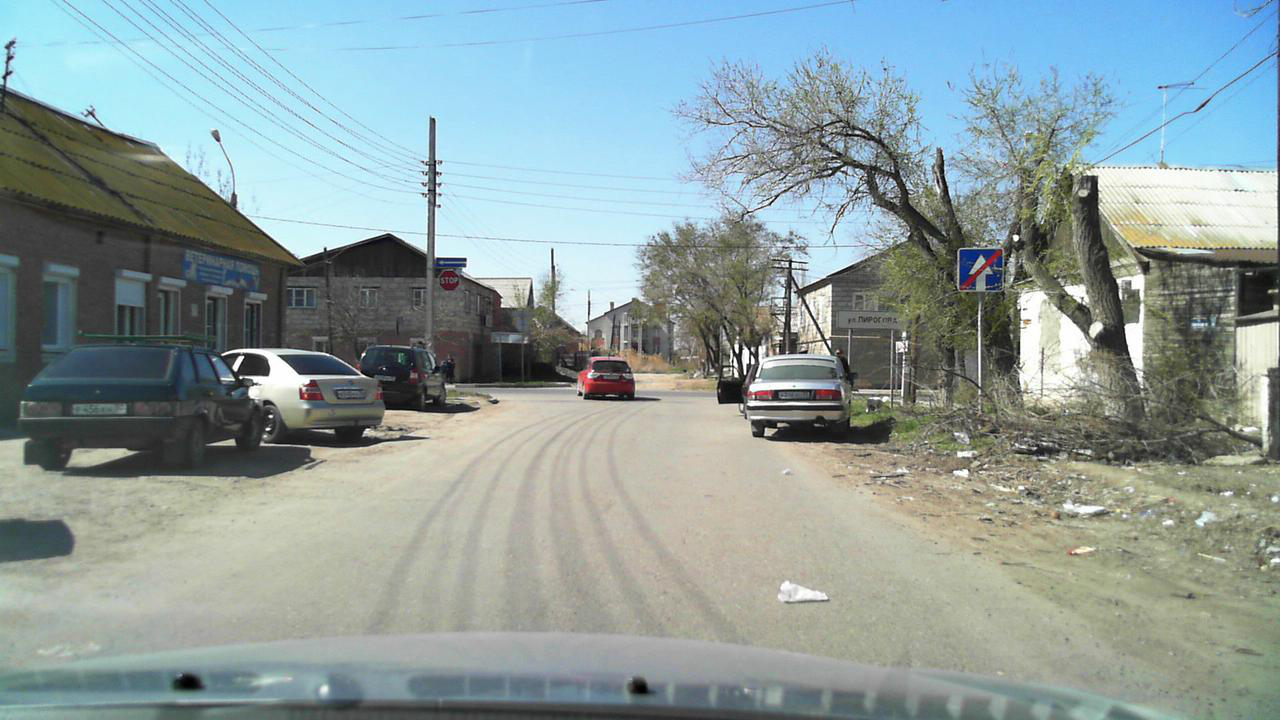

In [75]:
def prepare_image(path, target_size):
    image = load_img(path, target_size=(target_size[1], target_size[0]), interpolation='lanczos')
    display(image)
    data = img_to_array(image)
    data = np.divide(image, 255.)
    data = np.transpose(image, [1, 0, 2])
    data = np.expand_dims(image, axis=0)
    image = image.convert('RGBA')
    return image, data

reference_image, data = prepare_image('dataset/validation/0000022.jpg', (1280, 720))

## Обработка сетью изображения

In [62]:
prediction = model.predict(data)
print('Слои, доступные для вывода и их глубина')
names, depth = [], []
for i, layer in enumerate(model.layers):
    names.append(layer.name)
    depth.append(layer.output_shape[3])
display(pd.DataFrame(columns=['Слои', 'Глубина'], data = np.transpose([names, depth])))

Слои, доступные для вывода и их глубина


,Слои,Глубина
0,Input,3
1,Convolutional_1,32
2,Convolutional_2,32
3,Max_Pooling_2,32
4,Convolutional_3,48
5,Convolutional_4,48
6,Max_Pooling_3,48
7,Convolutional_5,64
8,Convolutional_6,64
9,Max_Pooling_4,64


# Вывод карт признаков

In [91]:
def legend_text(value, depth, index):
    return 'Максимальная активация: {} \n' \
           'Номер карты признаков: {} \n' \
           'Индекс слоя: {} \n' \
        .format(str(value), str(depth), str(index))


def display_fm(layer_index, fm_numbers):
    for i in fm_numbers:
        feature_map = prediction[layer_index][0, :, :, i]
        max_val = np.max(feature_map)
        if max_val != 0:
            feature_map = np.divide(feature_map, max_val)
        feature_map = np.multiply(feature_map, 255.)
        image = Image.fromarray(feature_map)
        image = image.resize(reference_image.size)
        image = image.convert('RGBA')
        if feature_map.shape[0] < reference_image.size[0] // 4:
            image = Image.blend(reference_image, image, 0.7)
        legend = legend_text(max_val, i, layer_index)
        draw_legend(image, legend)
        display(image)

In [ ]:
display_fm(6, range(0, 8))